In [50]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import norm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [68]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 100000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [76]:
df = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')
df_control = df.query("experimentVariant == 'Control' and value < 1000")[['value']]
df_treatment = df.query("experimentVariant == 'Treatment' and value < 1000")[['value']]

In [70]:
#

  0%|          | 0/100000 [00:00<?, ?it/s]

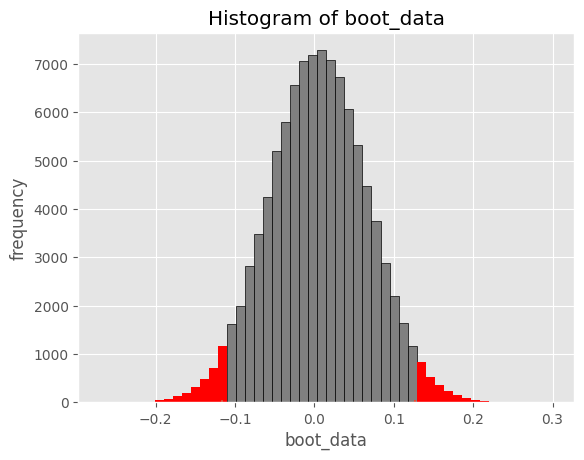

In [77]:
booted_data = get_bootstrap(df_control, df_treatment) # в результате хранится разница двух распределений, ДИ и pvalue

In [78]:
booted_data["p_value"] # альфа

0.9339005460530487

In [ ]:
#

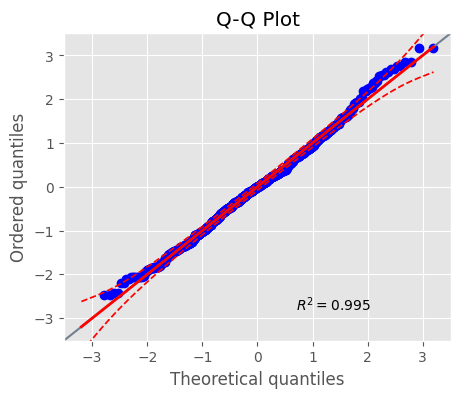

In [79]:
ax = pg.qqplot(df.query("value < 1000").value, dist='norm')

In [66]:
print(pg.normality(df.value)) 

            W  pval  normal
value  0.0422   0.0   False


In [67]:
pg.ttest(df_control.value, df_treatment.value, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.072902,998,two-sided,0.038438,"[-33.67, -0.92]",0.131102,0.586,0.544197


In [51]:
#

In [52]:
mannwhitneyu(df_control.value, df_treatment.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)